In [1]:
import numpy as np
import scipy
import math
import time
import itertools
from functools import reduce
from scipy.optimize import minimize

In [2]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import DensityMatrix, Statevector, Operator, partial_trace
import matplotlib.pyplot as plt
import networkx as nx

## function: from density_matrix to non-stabilizerness

In [3]:
def fast_pauli_spectrum(rho: np.ndarray, n: int) -> np.ndarray:
    """
    Calculates the Pauli spectrum using a robust Fast Walsh-Hadamard Transform.
    This version correctly reshapes the tensor and applies the transform iteratively.
    """
    d = 2**n
    
    # 1. Reshape rho from (2^n, 2^n) into a tensor representing n qubits for rows and n for columns.
    # Shape: (2, 2, ..., 2) with 2n dimensions.
    tensor = rho.reshape([2] * (2 * n))
    
    # 2. Transpose to group row/col axes for each qubit together.
    # The goal is to change the order from [row_q0, row_q1,... col_q0, col_q1,...]
    # to [row_q0, col_q0, row_q1, col_q1, ...].
    transpose_order = [val for pair in zip(range(n), range(n, 2 * n)) for val in pair]
    tensor = tensor.transpose(transpose_order)
    
    # 3. Reshape into a tensor where each of the n axes represents a single qubit's 
    # 2x2 density matrix, flattened to a vector of size 4.
    # Shape becomes (4, 4, ..., 4) with n axes.
    tensor = tensor.reshape([4] * n)
    
    # This is the core transformation matrix that calculates Tr(P @ M) for a 2x2 matrix M
    # where M is represented as a vector [M00, M01, M10, M11].
    transform_matrix = np.array([
        [1, 0, 0, 1],       # Tr(I @ M) = M00 + M11
        [0, 1, 1, 0],       # Tr(X @ M) = M10 + M01
        [0, -1j, 1j, 0],    # Tr(Y @ M) = -i*M01 + i*M10
        [1, 0, 0, -1]       # Tr(Z @ M) = M00 - M11
    ], dtype=np.complex128)

    # 4. Apply the Hadamard-like transform along each axis (for each qubit).
    for i in range(n):
        # We use tensordot to apply the matrix multiplication along axis i.
        # This is the most direct way to say "multiply transform_matrix with the i-th dimension".
        tensor = np.tensordot(tensor, transform_matrix, axes=([0], [1]))
        
    # After n transformations, the tensor contains all the trace values.
    traces = tensor.flatten()
    
    # 5. Calculate the final spectrum.
    eta = (traces.real**2) / d
    return eta

def Renyi(rho, alpha=2):
    if alpha == 1:
        raise Exception
    rho_alpha = np.linalg.matrix_power(rho, alpha)
    return 1/(1-alpha)*np.log(np.trace(rho_alpha).real)

def non_stablizerness_dm(rho, n, alpha = 2):
    if alpha == 1:
            raise Exception
    eta = fast_pauli_spectrum(rho, n)
    d = 2**n
    ns =  1/(1-alpha)*np.log(np.sum(eta**alpha))-np.log(d)
    return ns-Renyi(rho, alpha) 


def get_ns_func(pauli_spec, n_qubits_total, alpha = 2):
    d = 2**n_qubits_total
    ns =  1/(1-alpha)*np.log(np.sum(pauli_spec**alpha))-np.log(d)
    return ns

def non_stablizerness_dm_sv(state_vector, alpha = 2):
    if alpha == 1:
            raise Exception
    psi = state_vector.data
    rho = np.outer(psi, psi.conj())
    n = state_vector.num_qubits
    eta = fast_pauli_spectrum(rho, n)
    d = 2**n
    ns =  1/(1-alpha)*np.log(np.sum(eta**alpha))-np.log(d)
    return ns-Renyi(rho, alpha) 

### T_unit 

In [4]:
def T_projector():
    I = np.eye(2)
    X = np.array([[0,1],[1,0]])
    Y = np.array([[0,-1j],[1j,0]])
    Z = np.array([[1,0],[0,-1]])
    return (I+(X+Y+Z)/np.sqrt(3))/2

T_dm = T_projector()

def get_T_ns_unit(alpha=2):
    return non_stablizerness_dm(T_dm, 1, alpha=alpha)

T_unit = get_T_ns_unit()
T_unit

0.4054651081081643

### generate graph state from edges

In [5]:
def create_graph_state(n_qubits, edges):
    """
    Generates the Qiskit quantum circuit for a graph state.

    Args:
        n_qubits: The number of qubits (vertices) in the graph.
        edges: A list of tuples, where each tuple (i, j) represents an
               edge connecting qubit i and qubit j.

    Returns:
        A Qiskit QuantumCircuit that prepares the specified graph state.
    """
    # 1. Input validation
    if n_qubits <= 0:
        raise ValueError("Number of qubits must be positive.")
    for u, v in edges:
        if not (0 <= u < n_qubits and 0 <= v < n_qubits):
            raise ValueError(f"Edge ({u},{v}) is invalid for {n_qubits} qubits.")

    # 2. Create a quantum circuit with n qubits
    circuit = QuantumCircuit(n_qubits)

    # 3. Apply the Hadamard layer to all qubits
    circuit.h(range(n_qubits))

    # 4. Apply the entangling layer (CZ gates) for each edge
    for u, v in edges:
        circuit.cz(u, v)
        
    return circuit

def create_graph_state_vector(n_qubits, edges):
    circuit = create_graph_state(n_qubits, edges)
    return Statevector(circuit)

def visualize_graph(n_qubits, edges):
    """
    Creates and displays a visualization of the graph.
    """
    G = nx.Graph()
    G.add_nodes_from(range(n_qubits))
    G.add_edges_from(edges)
    
    pos = nx.spring_layout(G, seed=42) # for reproducible layout
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=700, font_size=16, font_weight='bold')
    plt.title("Quantum State Graph")
    plt.show()

def one_qubit_dm(theta, phi):
    H, V = np.array([1,0], dtype=np.complex64), np.array([0,1], dtype=np.complex64)
    psi = np.cos(theta/2)*H + np.sin(theta/2)*np.exp(1j*phi)*V
    return np.outer(psi, psi.conj())

def perform_measurement(input_dm: DensityMatrix, qubit_to_measure: int, theta: float, phi: float) -> DensityMatrix:
    M_op = Operator(one_qubit_dm(theta, phi))
    post_measurement_dm = input_dm.evolve(M_op, qargs=[qubit_to_measure])
    
    return post_measurement_dm

## adaptive method to get NS

In [9]:
def objective_function(angles, initial_dm, qubits_to_measure, measurement_type, alpha=2):
    current_dm = initial_dm
    n_qubits_total = initial_dm.num_qubits
    
    if measurement_type == '1-param':
        thetas = [np.pi / 2] * len(qubits_to_measure)
        phis = angles
    else: # '2-param'
        thetas = angles[0::2]
        phis = angles[1::2]

    for i, qubit_idx in enumerate(qubits_to_measure):
        current_dm = perform_measurement(current_dm, qubit_idx, thetas[i], phis[i])
    
    qubits_to_keep = sorted(list(set(range(n_qubits_total)) - set(qubits_to_measure)))

    rho_full_system = current_dm
    rho_reserved = partial_trace(rho_full_system, list(qubits_to_measure))
    rho_reserved = rho_reserved.data
    rho_reserved = rho_reserved/np.trace(rho_reserved)
    ns = non_stablizerness_dm(rho_reserved, len(qubits_to_keep)) 

    return -ns

def is_valid_peeling_order(order, n_qubits, edges) -> bool:
    """
    Checks if a measurement order follows the 'graph peeling' condition, i.e from outer layer to inner layer
    """
    if len(order) <= 1:
        return True
    G = nx.Graph()
    G.add_nodes_from(range(n_qubits))
    G.add_edges_from(edges)
    for qubit_to_measure in order:
        if not G.nodes: return False 
        degrees = dict(G.degree())
        if not degrees: return True
        min_degree = min(degrees.values())
        outer_layer = {node for node, deg in degrees.items() if deg == min_degree}
        if qubit_to_measure not in outer_layer:
            return False
        G.remove_node(qubit_to_measure)
    return True


def search_max_NS(initial_state_dm, n, k_values_to_check, graph_edges, MEASUREMENT_TYPE, alpha = 2):
    """
    Performs an addaptive search over measurement angles to find the combination that maximizes the NS value transerse all logical measurement orders (one that satisfies is_valid_peer_order).

    Args:
        initial_state_dm: The initial DensityMatrix of the graph state.
        n: number of qubits.
        k_values_to_check: the number of measurement qubits.
        graph_edges: graph edges, to get the outer later
        MEASUREMENT_TYPE: '1-param' or '2-param'. 
        alpha: alpha-Renyi entropy of the Pauli spectrum

    Returns:
        a tuple of (max_ns, best_config), best_config contains the measured qubits and order and the corresponding angles.
    """
    global_max_ns = 0
    best_config = {}

    for k in k_values_to_check:
        #print(f"\n--- Checking measurements of k={k} qubits ---")
        qubit_indices = list(range(n))
        
        for qubits in itertools.combinations(qubit_indices, k):
            for order in itertools.permutations(qubits):
                #print(f"Optimizing for measurement order: {order}")

                if not is_valid_peeling_order(order, n, graph_edges):
                    continue

                if MEASUREMENT_TYPE == '1-param':
                    num_angles = k
                    bounds = [(0, 2 * np.pi)] * num_angles
                else: # '2-param'
                    num_angles = 2 * k
                    bounds = [(0, np.pi), (0, 2 * np.pi)] * k
                
                initial_guess = np.random.rand(num_angles) * [b[1] for b in bounds]

                result = minimize(
                    fun=objective_function,
                    x0=initial_guess,
                    args=(initial_state_dm, order, MEASUREMENT_TYPE, alpha),
                    method='L-BFGS-B',
                    bounds=bounds,
                    options={'maxiter': 200, 'ftol': 1e-9}
                )

                current_max_ns = -result.fun
                #print(f"  Max NS found: {current_max_ns:.6f}")

                if current_max_ns > global_max_ns:
                    global_max_ns = current_max_ns
                    best_config = {
                        'ns_value': current_max_ns,
                        'k_measured': k,
                        'order': order,
                        'angles': result.x.tolist(),
                        'type': MEASUREMENT_TYPE
                    }
    return (global_max_ns, best_config)


### test adaptive method

In [86]:
n = 4

graph_edges = [(0,1), (1,2), (2,3), (3,0)]
initial_state_vector = create_graph_state_vector(n, graph_edges)
initial_state_dm = DensityMatrix(initial_state_vector)
print(f"--- Starting NS Maximization for {n}-qubit Graph State ---")
print(f"Graph Edges: {graph_edges}\n")

MEASUREMENT_TYPE = '1-param'
k_values_to_check = [1,2]
alpha = 2

global_max_ns, best_config = search_max_NS(initial_state_dm, n, k_values_to_check, graph_edges, MEASUREMENT_TYPE, alpha)

print(f"The global max NS (T_unit): {global_max_ns/T_unit}")
print(f"The best config is: {best_config}")

--- Starting NS Maximization for 4-qubit Graph State ---
Graph Edges: [(0, 1), (1, 2), (2, 3), (3, 0)]

The global max NS (T_unit): 1.3434476702480007
The best config is: {'ns_value': 0.544721154854767, 'k_measured': 2, 'order': (3, 2), 'angles': [2.2384228437484968, 5.596139677936571], 'type': '1-param'}


## brutal-force method to get NS

In [7]:
def grid_search_angles(initial_dm: DensityMatrix, 
                         order: tuple, 
                         measurement_type: str, 
                         num_steps: int,
                         alpha: int):
    """
    Performs an exhaustive grid search over all measurement angles to find the
    combination that maximizes the NS value for a SINGLE, specific measurement order.

    Args:
        initial_sv: The initial Statevector of the graph state.
        order: The fixed measurement order to test (e.g., (0, 1)).
        measurement_type: '1-param' or '2-param'.
        get_ns_func: The function that calculates NS from a Pauli spectrum.
        num_steps: The number of points to check for each angle (resolution).

    Returns:
        A dictionary containing the maximum NS value and the angles that produced it.
    """
    print(f"\n--- Starting Grid Search for order: {order} ---")
    print(f"Angle resolution (num_steps): {num_steps}")

    max_ns = -1.0
    best_angles = None
    k = len(order)

    # Define the discrete angle ranges to iterate over
    phi_range = np.linspace(0, 2 * np.pi, num_steps, endpoint=False) # endpoint=False as 0 and 2pi are the same
    
    # --- Prepare the iterator for all angle combinations ---
    if measurement_type == '1-param':
        num_params_per_qubit = 1
        angle_combinations = itertools.product(phi_range, repeat=k)
    else: # '2-param'
        num_params_per_qubit = 2
        theta_range = np.linspace(0, np.pi, num_steps)
        # Create a list of all possible (theta, phi) pairs for one qubit
        single_qubit_angles = list(itertools.product(theta_range, phi_range))
        # Now create combinations of these pairs for all k qubits
        angle_combinations = itertools.product(single_qubit_angles, repeat=k)

    # --- Calculate total iterations for a progress bar ---
    total_iterations = num_steps ** (k * num_params_per_qubit)
    print(f"Total points to check: {total_iterations}")
    
    # --- Iterate through every point on the grid ---
    for i, angle_combo in enumerate(angle_combinations):
        
        if (i + 1) % (max(1, total_iterations // 20)) == 0: # Print progress roughly 20 times
            progress = (i + 1) / total_iterations
            print(f"\rProgress: [{int(progress * 20) * '='}>{(19 - int(progress * 20)) * ' '}] {progress:.1%}", end="")

        if measurement_type == '1-param':
            # angle_combo is already flat: (phi1, phi2, ...)
            angles_for_objective = angle_combo
        else:
            # angle_combo is nested: ((t1, p1), (t2, p2), ...), so we flatten it
            angles_for_objective = [angle for pair in angle_combo for angle in pair]
        
        # We can reuse the objective_function, as it does the core calculation
        # Remember it returns -NS, so we flip the sign back

        current_ns = -objective_function(
            angles_for_objective,
            initial_dm,
            order,
            measurement_type,
            alpha
        )

        if current_ns > max_ns:
            max_ns = current_ns
            best_angles = angles_for_objective

    print("\nGrid search complete.")
    return (max_ns, best_angles)

# Simulation with brutal force method

--- Starting NS Maximization for 3-qubit Graph State ---
Graph Edges: [(0, 1), (1, 2)]


--- Starting Grid Search for order: (0, 1) ---
Angle resolution (num_steps): 17
Total points to check: 289
Progress: [===================>] 96.9%
Grid search complete.
The global max NS (T_unit): 0.9943434794120272
The best config is: (2.2175948142986774, 5.543987035746694)


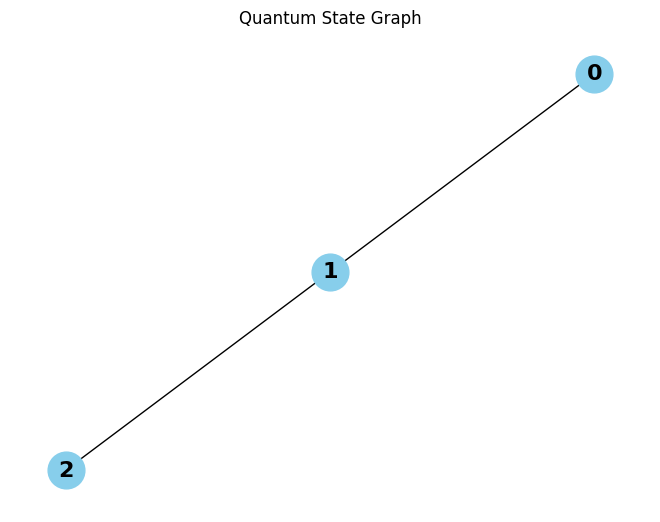

In [14]:
n = 3

graph_edges = [(0,1), (1,2)] # triangle
initial_state_vector = create_graph_state_vector(n, graph_edges)
initial_state_dm = DensityMatrix(initial_state_vector)
print(f"--- Starting NS Maximization for {n}-qubit Graph State ---")
print(f"Graph Edges: {graph_edges}\n")

MEASUREMENT_TYPE = '1-param'
alpha = 2

global_max_ns, best_angles = grid_search_angles(initial_state_dm, order=(0,1), measurement_type=MEASUREMENT_TYPE, num_steps=17, alpha=2)

print(f"The global max NS (T_unit): {global_max_ns/T_unit}")
print(f"The best config is: {best_angles}")

visualize_graph(n, graph_edges)

### graph state: triangle

--- Starting NS Maximization for 3-qubit Graph State ---
Graph Edges: [(0, 1), (1, 2), (2, 0)]


--- Starting Grid Search for order: (0, 1) ---
Angle resolution (num_steps): 17
Total points to check: 289
Progress: [===================>] 96.9%
Grid search complete.
The global max NS (T_unit): 0.7094737725114268
The best config is: (1.8479956785822313, 4.065590492880909)


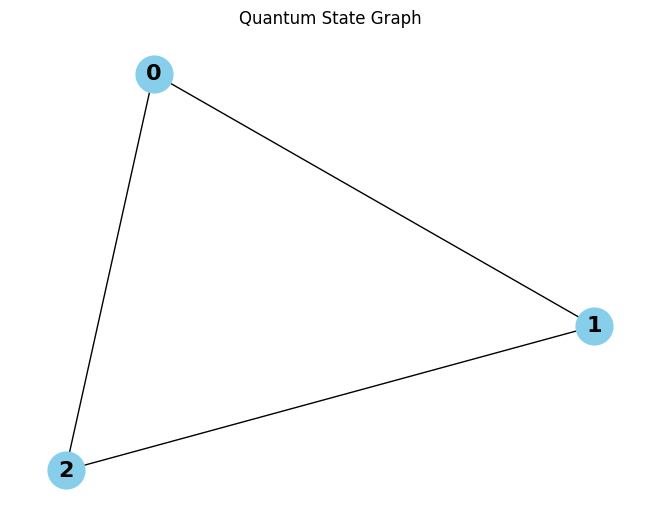

In [10]:
n = 3

graph_edges = [(0,1), (1,2), (2,0)] # triangle
initial_state_vector = create_graph_state_vector(n, graph_edges)
initial_state_dm = DensityMatrix(initial_state_vector)
print(f"--- Starting NS Maximization for {n}-qubit Graph State ---")
print(f"Graph Edges: {graph_edges}\n")

MEASUREMENT_TYPE = '1-param'
alpha = 2

global_max_ns, best_angles = grid_search_angles(initial_state_dm, order=(0,1), measurement_type=MEASUREMENT_TYPE, num_steps=17, alpha=2)

print(f"The global max NS (T_unit): {global_max_ns/T_unit}")
print(f"The best config is: {best_angles}")

visualize_graph(n, graph_edges)

--- Starting NS Maximization for 3-qubit Graph State ---
Graph Edges: [(0, 1), (1, 2), (2, 0)]


--- Starting Grid Search for order: (0,) ---
Angle resolution (num_steps): 17
Total points to check: 289
Progress: [===================>] 96.9%
Grid search complete.
The global max NS (T_unit): 0.9945533976059445
The best config is: [0.9817477042468103, 0.7391982714328925]


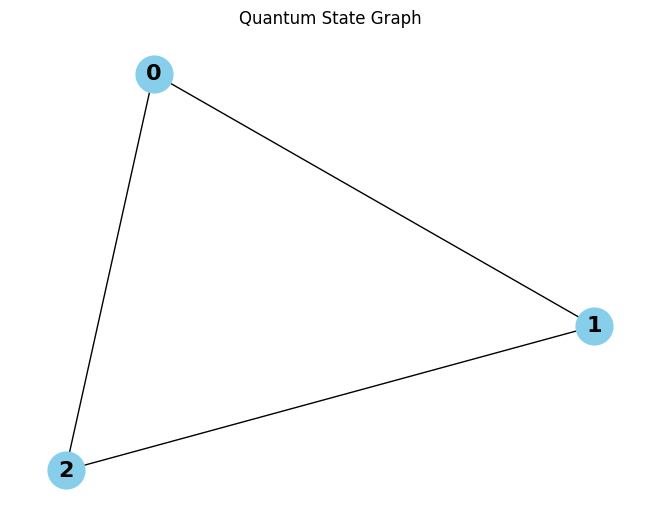

In [79]:
n = 3

graph_edges = [(0,1), (1,2), (2,0)] # triangle
initial_state_vector = create_graph_state_vector(n, graph_edges)
initial_state_dm = DensityMatrix(initial_state_vector)
print(f"--- Starting NS Maximization for {n}-qubit Graph State ---")
print(f"Graph Edges: {graph_edges}\n")

MEASUREMENT_TYPE = '2-param'
alpha = 2

global_max_ns, best_angles = grid_search_angles(initial_state_dm, order=(0,), measurement_type=MEASUREMENT_TYPE, num_steps=17, alpha=2)

print(f"The global max NS (T_unit): {global_max_ns/T_unit}")
print(f"The best config is: {best_angles}")

visualize_graph(n, graph_edges)

### graph stae: box

--- Starting NS Maximization for 4-qubit Graph State ---
Graph Edges: [(0, 1), (1, 2), (2, 3), (3, 0)]


--- Starting Grid Search for order: (0, 1) ---
Angle resolution (num_steps): 17
Total points to check: 289
Progress: [===================>] 96.9%
Grid search complete.
The global max NS (T_unit): 1.4050445692142897
The best config is: (0.7391982714328925, 0.7391982714328925)


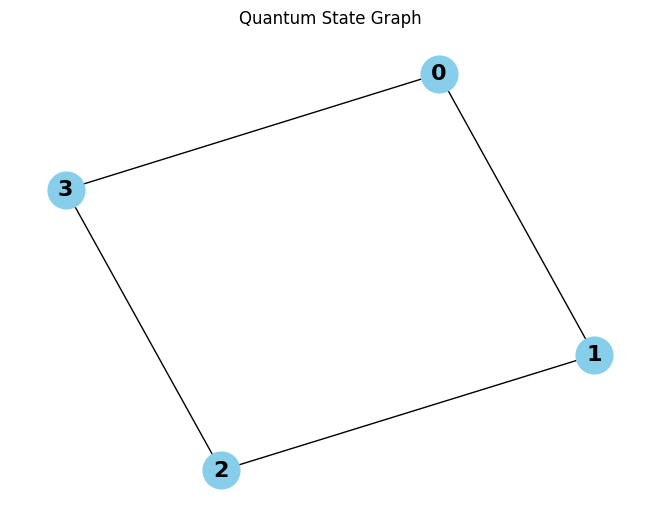

In [67]:
n = 4

graph_edges = [(0,1), (1,2), (2,3), (3,0)] # box-edge
initial_state_vector = create_graph_state_vector(n, graph_edges)
initial_state_dm = DensityMatrix(initial_state_vector)
print(f"--- Starting NS Maximization for {n}-qubit Graph State ---")
print(f"Graph Edges: {graph_edges}\n")

MEASUREMENT_TYPE = '1-param'
alpha = 2

global_max_ns, best_angles = grid_search_angles(initial_state_dm, order=(0,1), measurement_type=MEASUREMENT_TYPE, num_steps=17, alpha=2)

print(f"The global max NS (T_unit): {global_max_ns/T_unit}")
print(f"The best config is: {best_angles}")

visualize_graph(n, graph_edges)

--- Starting NS Maximization for 4-qubit Graph State ---
Graph Edges: [(0, 1), (1, 2), (2, 3), (3, 0)]


--- Starting Grid Search for order: (0, 1) ---
Angle resolution (num_steps): 17
Total points to check: 83521
Progress: [===================>] 100.0%
Grid search complete.
The global max NS (T_unit): 1.9891067952118897
The best config is: [0.9817477042468103, 0.7391982714328925, 0.9817477042468103, 0.7391982714328925]


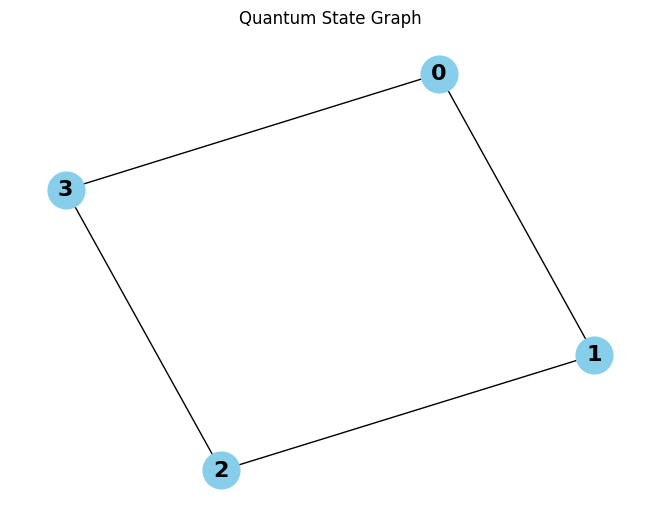

In [68]:
n = 4

graph_edges = [(0,1), (1,2), (2,3), (3,0)] # box-edge
initial_state_vector = create_graph_state_vector(n, graph_edges)
initial_state_dm = DensityMatrix(initial_state_vector)
print(f"--- Starting NS Maximization for {n}-qubit Graph State ---")
print(f"Graph Edges: {graph_edges}\n")

MEASUREMENT_TYPE = '2-param'
alpha = 2

global_max_ns, best_angles = grid_search_angles(initial_state_dm, order=(0,1), measurement_type=MEASUREMENT_TYPE, num_steps=17, alpha=2)

print(f"The global max NS (T_unit): {global_max_ns/T_unit}")
print(f"The best config is: {best_angles}")

visualize_graph(n, graph_edges)

### graph state: box with bi-diagnoal cross

--- Starting NS Maximization for 4-qubit Graph State ---
Graph Edges: [(0, 1), (1, 2), (2, 3), (3, 0), (0, 2), (1, 3)]


--- Starting Grid Search for order: (0, 1) ---
Angle resolution (num_steps): 17
Total points to check: 289
Progress: [===================>] 96.9%
Grid search complete.
The global max NS (T_unit): 0.7094737725114268
The best config is: (1.8479956785822313, 4.065590492880909)


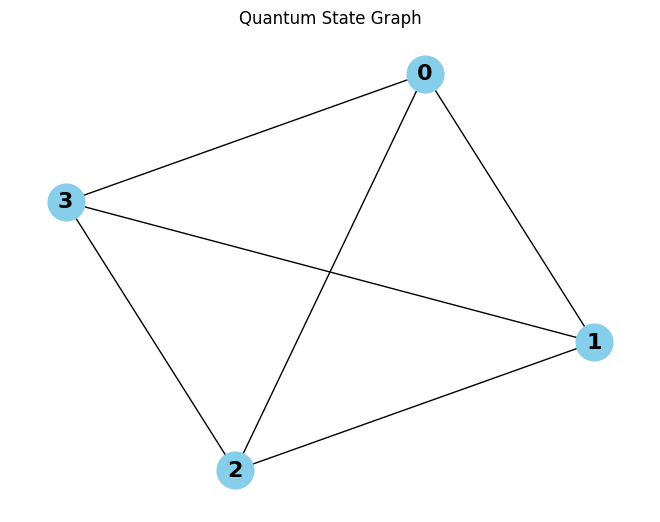

In [69]:
n = 4

graph_edges = [(0,1), (1,2), (2,3), (3,0), (0,2), (1,3)] # box-edge
initial_state_vector = create_graph_state_vector(n, graph_edges)
initial_state_dm = DensityMatrix(initial_state_vector)
print(f"--- Starting NS Maximization for {n}-qubit Graph State ---")
print(f"Graph Edges: {graph_edges}\n")

MEASUREMENT_TYPE = '1-param'
alpha = 2

global_max_ns, best_angles = grid_search_angles(initial_state_dm, order=(0,1), measurement_type=MEASUREMENT_TYPE, num_steps=17, alpha=2)

print(f"The global max NS (T_unit): {global_max_ns/T_unit}")
print(f"The best config is: {best_angles}")

visualize_graph(n, graph_edges)

--- Starting NS Maximization for 4-qubit Graph State ---
Graph Edges: [(0, 1), (1, 2), (2, 3), (3, 0), (0, 2), (1, 3)]


--- Starting Grid Search for order: (0, 1) ---
Angle resolution (num_steps): 17
Total points to check: 83521
Progress: [===================>] 100.0%
Grid search complete.
The global max NS (T_unit): 0.9999558750587791
The best config is: [2.356194490192345, 0.36959913571644626, 2.748893571891069, 1.478396542865785]


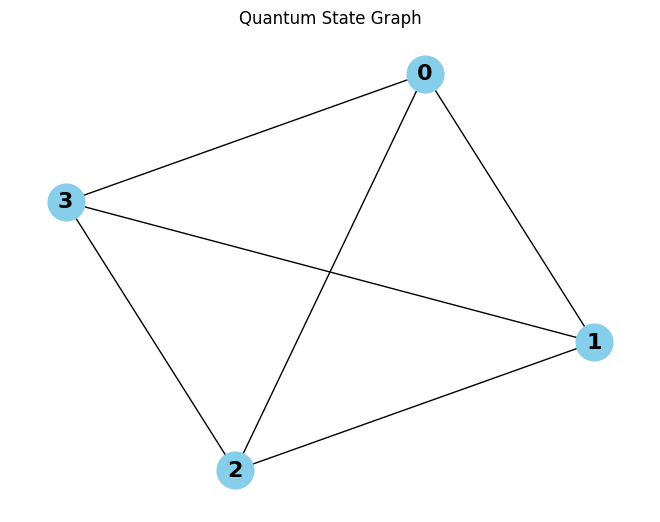

In [70]:
n = 4

graph_edges = [(0,1), (1,2), (2,3), (3,0), (0,2), (1,3)] # box-edge
initial_state_vector = create_graph_state_vector(n, graph_edges)
initial_state_dm = DensityMatrix(initial_state_vector)
print(f"--- Starting NS Maximization for {n}-qubit Graph State ---")
print(f"Graph Edges: {graph_edges}\n")

MEASUREMENT_TYPE = '2-param'
alpha = 2

global_max_ns, best_angles = grid_search_angles(initial_state_dm, order=(0,1), measurement_type=MEASUREMENT_TYPE, num_steps=17, alpha=2)

print(f"The global max NS (T_unit): {global_max_ns/T_unit}")
print(f"The best config is: {best_angles}")

visualize_graph(n, graph_edges)

### graph state: Pentagram

--- Starting NS Maximization for 5-qubit Graph State ---
Graph Edges: [(0, 2), (2, 4), (4, 1), (1, 3), (3, 0)]


--- Starting Grid Search for order: (0, 1, 2) ---
Angle resolution (num_steps): 17
Total points to check: 4913
Progress: [===================>] 99.7%
Grid search complete.
The global max NS (T_unit): 1.4496443981437062
The best config is: (1.478396542865785, 2.95679308573157, 1.478396542865785)


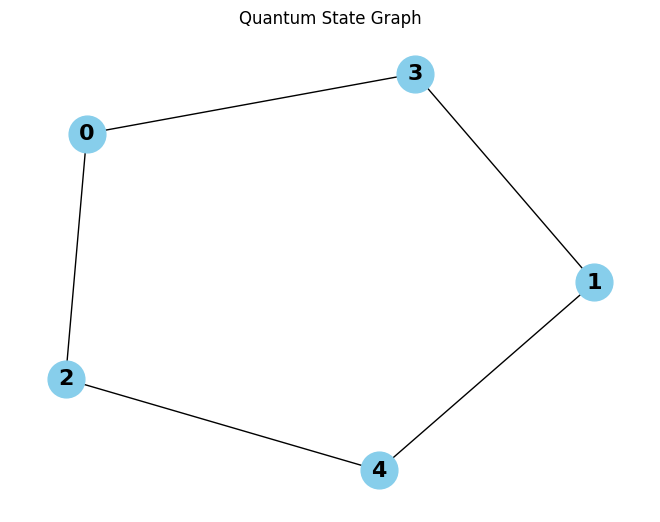

In [71]:
n = 5

graph_edges = [(0,2), (2,4), (4,1), (1,3), (3,0)] # Pentagram
initial_state_vector = create_graph_state_vector(n, graph_edges)
initial_state_dm = DensityMatrix(initial_state_vector)
print(f"--- Starting NS Maximization for {n}-qubit Graph State ---")
print(f"Graph Edges: {graph_edges}\n")

MEASUREMENT_TYPE = '1-param'
alpha = 2

global_max_ns, best_angles = grid_search_angles(initial_state_dm, order=(0,1,2), measurement_type=MEASUREMENT_TYPE, num_steps=17, alpha=2)

print(f"The global max NS (T_unit): {global_max_ns/T_unit}")
print(f"The best config is: {best_angles}")

visualize_graph(n, graph_edges)

--- Starting NS Maximization for 5-qubit Graph State ---
Graph Edges: [(0, 2), (2, 4), (4, 1), (1, 3), (3, 0)]


--- Starting Grid Search for order: (0, 1) ---
Angle resolution (num_steps): 17
Total points to check: 83521
Progress: [===================>] 100.0%
Grid search complete.
The global max NS (T_unit): 1.9891067952118897
The best config is: [0.9817477042468103, 0.7391982714328925, 0.9817477042468103, 0.7391982714328925]


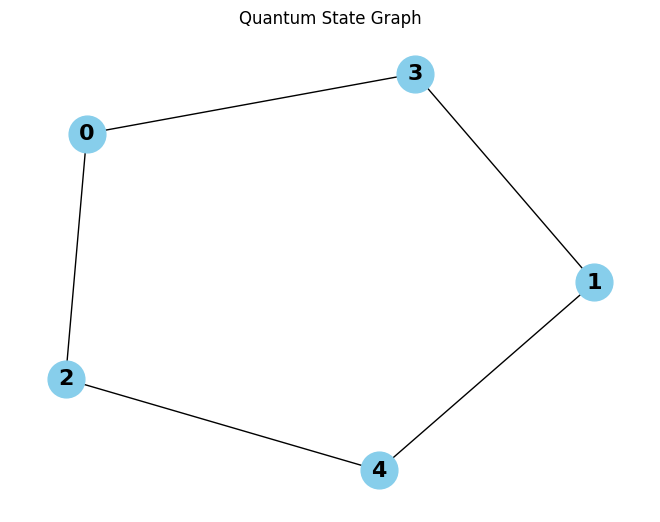

In [72]:
n = 5

graph_edges = [(0,2), (2,4), (4,1), (1,3), (3,0)] # Pentagram
initial_state_vector = create_graph_state_vector(n, graph_edges)
initial_state_dm = DensityMatrix(initial_state_vector)
print(f"--- Starting NS Maximization for {n}-qubit Graph State ---")
print(f"Graph Edges: {graph_edges}\n")

MEASUREMENT_TYPE = '2-param'
alpha = 2

global_max_ns, best_angles = grid_search_angles(initial_state_dm, order=(0,1), measurement_type=MEASUREMENT_TYPE, num_steps=17, alpha=2)

print(f"The global max NS (T_unit): {global_max_ns/T_unit}")
print(f"The best config is: {best_angles}")

visualize_graph(n, graph_edges)

--- Starting NS Maximization for 5-qubit Graph State ---
Graph Edges: [(0, 2), (2, 4), (4, 1), (1, 3), (3, 0)]


--- Starting Grid Search for order: (0, 1, 2) ---
Angle resolution (num_steps): 5
Total points to check: 15625
Progress: [===================>] 100.0%
Grid search complete.
The global max NS (T_unit): 1.9983020790591763
The best config is: [0.7853981633974483, 0.0, 0.7853981633974483, 1.2566370614359172, 2.356194490192345, 0.0]


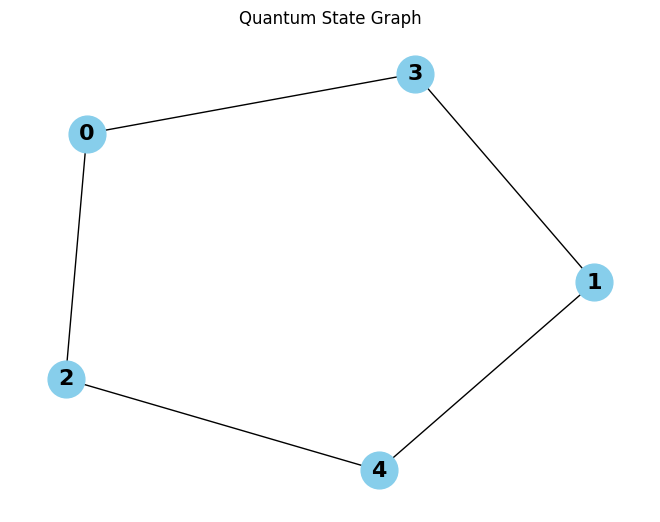

In [73]:
n = 5

graph_edges = [(0,2), (2,4), (4,1), (1,3), (3,0)] # Pentagram
initial_state_vector = create_graph_state_vector(n, graph_edges)
initial_state_dm = DensityMatrix(initial_state_vector)
print(f"--- Starting NS Maximization for {n}-qubit Graph State ---")
print(f"Graph Edges: {graph_edges}\n")

MEASUREMENT_TYPE = '2-param'
alpha = 2

global_max_ns, best_angles = grid_search_angles(initial_state_dm, order=(0,1,2), measurement_type=MEASUREMENT_TYPE, num_steps=5, alpha=2)

print(f"The global max NS (T_unit): {global_max_ns/T_unit}")
print(f"The best config is: {best_angles}")

visualize_graph(n, graph_edges)

### graph state: cyclic connected

--- Starting NS Maximization for 5-qubit Graph State ---
Graph Edges: [(0, 1), (1, 2), (2, 3), (3, 4), (4, 0)]


--- Starting Grid Search for order: (0, 1, 2) ---
Angle resolution (num_steps): 17
Total points to check: 4913
Progress: [===================>] 99.7%
Grid search complete.
The global max NS (T_unit): 1.438422243571874
The best config is: (0.7391982714328925, 4.435189628597355, 5.543987035746694)


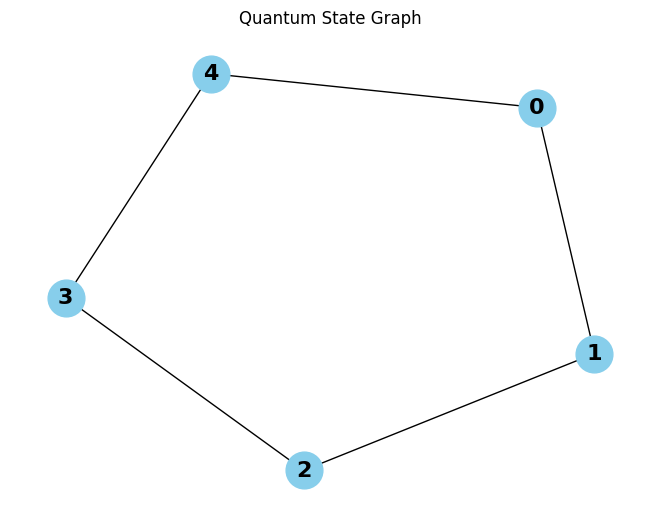

In [81]:
n = 5

graph_edges = [(0,1), (1,2), (2,3), (3,4), (4,0)] 
initial_state_vector = create_graph_state_vector(n, graph_edges)
initial_state_dm = DensityMatrix(initial_state_vector)
print(f"--- Starting NS Maximization for {n}-qubit Graph State ---")
print(f"Graph Edges: {graph_edges}\n")

MEASUREMENT_TYPE = '1-param'
alpha = 2

global_max_ns, best_angles = grid_search_angles(initial_state_dm, order=(0,1,2), measurement_type=MEASUREMENT_TYPE, num_steps=17, alpha=2)

print(f"The global max NS (T_unit): {global_max_ns/T_unit}")
print(f"The best config is: {best_angles}")

visualize_graph(n, graph_edges)

--- Starting NS Maximization for 5-qubit Graph State ---
Graph Edges: [(0, 1), (1, 2), (2, 3), (3, 4), (4, 0)]


--- Starting Grid Search for order: (0, 1) ---
Angle resolution (num_steps): 17
Total points to check: 83521
Progress: [===================>] 100.0%
Grid search complete.
The global max NS (T_unit): 1.9891067952118906
The best config is: [0.9817477042468103, 0.7391982714328925, 0.9817477042468103, 0.7391982714328925]


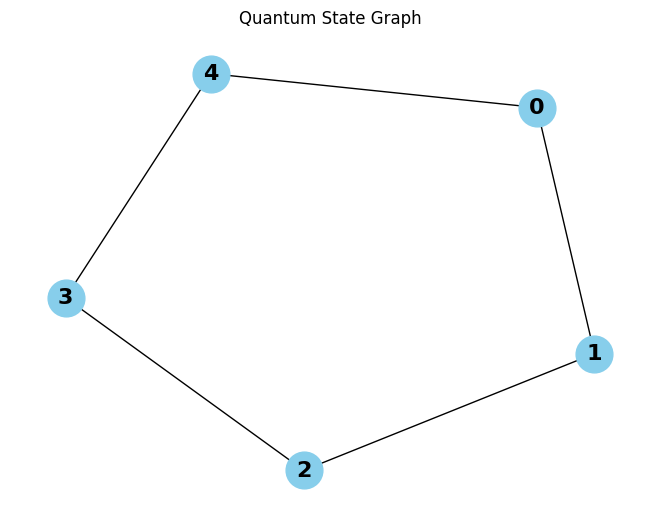

In [74]:
n = 5

graph_edges = [(0,1), (1,2), (2,3), (3,4), (4,0)] 
initial_state_vector = create_graph_state_vector(n, graph_edges)
initial_state_dm = DensityMatrix(initial_state_vector)
print(f"--- Starting NS Maximization for {n}-qubit Graph State ---")
print(f"Graph Edges: {graph_edges}\n")

MEASUREMENT_TYPE = '2-param'
alpha = 2

global_max_ns, best_angles = grid_search_angles(initial_state_dm, order=(0,1), measurement_type=MEASUREMENT_TYPE, num_steps=17, alpha=2)

print(f"The global max NS (T_unit): {global_max_ns/T_unit}")
print(f"The best config is: {best_angles}")

visualize_graph(n, graph_edges)

--- Starting NS Maximization for 5-qubit Graph State ---
Graph Edges: [(0, 1), (1, 2), (2, 3), (3, 4), (4, 0)]


--- Starting Grid Search for order: (0, 1, 2) ---
Angle resolution (num_steps): 5
Total points to check: 15625
Progress: [===============>    ] 80.0%

c:\Users\49140\anaconda3\envs\torch_qiskit\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


Progress: [===================>] 100.0%
Grid search complete.
The global max NS (T_unit): 1.9400465380523575
The best config is: [0.7853981633974483, 2.5132741228718345, 1.5707963267948966, 5.026548245743669, 2.356194490192345, 2.5132741228718345]


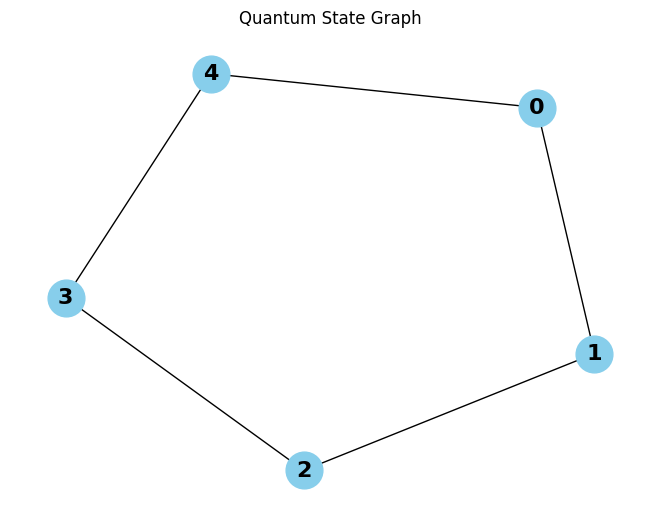

In [75]:
n = 5

graph_edges = [(0,1), (1,2), (2,3), (3,4), (4,0)] 
initial_state_vector = create_graph_state_vector(n, graph_edges)
initial_state_dm = DensityMatrix(initial_state_vector)
print(f"--- Starting NS Maximization for {n}-qubit Graph State ---")
print(f"Graph Edges: {graph_edges}\n")

MEASUREMENT_TYPE = '2-param'
alpha = 2

global_max_ns, best_angles = grid_search_angles(initial_state_dm, order=(0,1,2), measurement_type=MEASUREMENT_TYPE, num_steps=5, alpha=2)

print(f"The global max NS (T_unit): {global_max_ns/T_unit}")
print(f"The best config is: {best_angles}")

visualize_graph(n, graph_edges)

### graph state: 5 qubit full connected

--- Starting NS Maximization for 5-qubit Graph State ---
Graph Edges: [(0, 2), (2, 4), (4, 1), (1, 3), (3, 0), (0, 1), (1, 2), (2, 3), (3, 4), (4, 0)]


--- Starting Grid Search for order: (0,) ---
Angle resolution (num_steps): 17
Total points to check: 17
Progress: [====================>] 100.0%
Grid search complete.
The global max NS (T_unit): 0.7025222846071453
The best config is: (0.7391982714328925,)


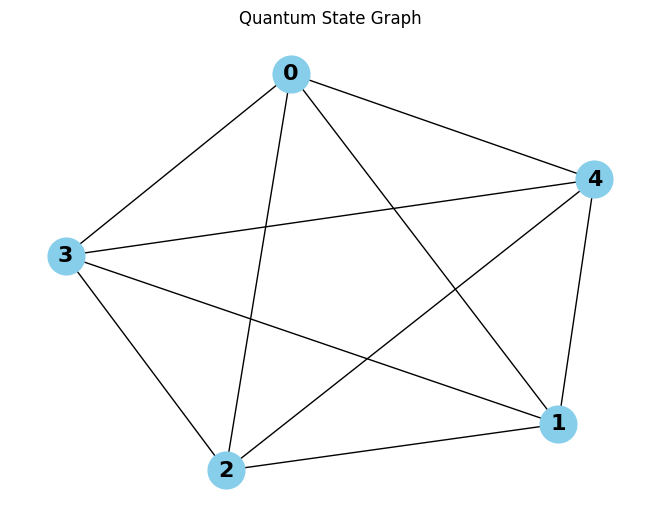

In [76]:
n = 5

graph_edges = [(0,2), (2,4), (4,1), (1,3), (3,0), (0,1), (1,2), (2,3), (3,4), (4,0)] 
initial_state_vector = create_graph_state_vector(n, graph_edges)
initial_state_dm = DensityMatrix(initial_state_vector)
print(f"--- Starting NS Maximization for {n}-qubit Graph State ---")
print(f"Graph Edges: {graph_edges}\n")

MEASUREMENT_TYPE = '1-param'
alpha = 2

global_max_ns, best_angles = grid_search_angles(initial_state_dm, order=(0,), measurement_type=MEASUREMENT_TYPE, num_steps=17, alpha=2)

print(f"The global max NS (T_unit): {global_max_ns/T_unit}")
print(f"The best config is: {best_angles}")

visualize_graph(n, graph_edges)

--- Starting NS Maximization for 5-qubit Graph State ---
Graph Edges: [(0, 2), (2, 4), (4, 1), (1, 3), (3, 0), (0, 1), (1, 2), (2, 3), (3, 4), (4, 0)]


--- Starting Grid Search for order: (0, 1) ---
Angle resolution (num_steps): 17
Total points to check: 83521
Progress: [===================>] 100.0%
Grid search complete.
The global max NS (T_unit): 0.9999558750587786
The best config is: [2.356194490192345, 0.36959913571644626, 2.748893571891069, 1.478396542865785]


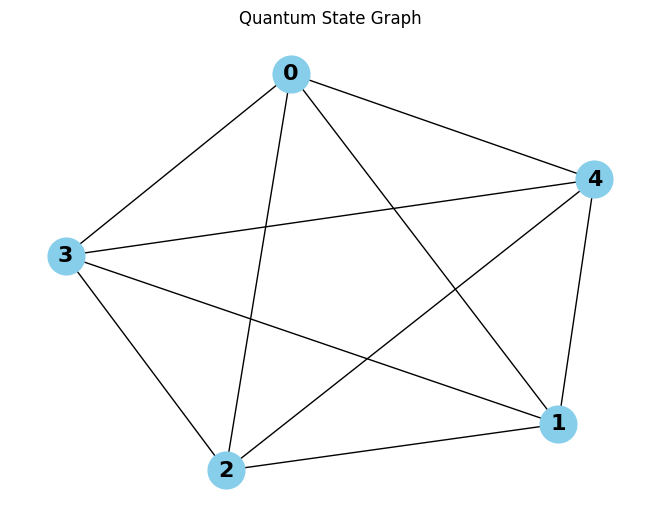

In [77]:
n = 5

graph_edges = [(0,2), (2,4), (4,1), (1,3), (3,0), (0,1), (1,2), (2,3), (3,4), (4,0)] 
initial_state_vector = create_graph_state_vector(n, graph_edges)
initial_state_dm = DensityMatrix(initial_state_vector)
print(f"--- Starting NS Maximization for {n}-qubit Graph State ---")
print(f"Graph Edges: {graph_edges}\n")

MEASUREMENT_TYPE = '2-param'
alpha = 2

global_max_ns, best_angles = grid_search_angles(initial_state_dm, order=(0,1), measurement_type=MEASUREMENT_TYPE, num_steps=17, alpha=2)

print(f"The global max NS (T_unit): {global_max_ns/T_unit}")
print(f"The best config is: {best_angles}")

visualize_graph(n, graph_edges)